In [21]:
import jax
import jax.numpy as jnp
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import sys
import tensorflow as tf
import tqdm
from typing import List, Sequence
sys.path.append("../")

from symphony.data import input_pipeline_tf

In [3]:
workdirs = {
    "nn_edm": "/radish/qm9_fragments_fixed_mad/nn_edm/",
    "radius":"/radish/qm9_fragments_fixed_mad/radius/",
}
train_molecules = (0, 100000)
val_molecules = (100000, 120000)
test_molecules = (120000, 135000)

In [11]:
def get_dataset(method, seed=0):
    # Set the seed for reproducibility.
    tf.random.set_seed(seed)

    # Root directory of the dataset.
    filenames = sorted(os.listdir(workdirs[method]))
    filenames = [
        os.path.join(workdirs[method], f)
        for f in filenames
        if f.startswith("fragments_")
    ]
    if len(filenames) == 0:
        raise ValueError(f"No files found in {workdirs[method]}.")

    # Partition the filenames into train, val, and test.
    def filter_by_molecule_number(
        filenames: Sequence[str], start: int, end: int
    ) -> List[str]:
        def filter_file(filename: str, start: int, end: int) -> bool:
            filename = os.path.basename(filename)
            _, file_start, file_end = [int(val) for val in re.findall(r"\d+", filename)]
            return start <= file_start and file_end <= end

        return [f for f in filenames if filter_file(f, start, end)]

    # Number of molecules for training can be smaller than the chunk size.
    all_files = filter_by_molecule_number(filenames, 0, 135000),

    element_spec = tf.data.Dataset.load(filenames[0]).element_spec
    dataset = tf.data.Dataset.from_tensor_slices(all_files)
    dataset = dataset.interleave(
        lambda x: tf.data.Dataset.load(x, element_spec=element_spec),
        num_parallel_calls=tf.data.AUTOTUNE,
        deterministic=True,
    )

    # Shuffle the dataset.
    dataset = dataset.shuffle(1000, seed=seed)

    # Convert to jraph.GraphsTuple.
    dataset = dataset.map(
        input_pipeline_tf._convert_to_graphstuple,
        num_parallel_calls=tf.data.AUTOTUNE,
        deterministic=True,
    )

    return dataset

In [22]:
num_targets = {"nn_edm": [], "radius": []}
for frag_method in workdirs:
    dataset = get_dataset(frag_method)
    for graph in tqdm.tqdm(dataset.as_numpy_iterator()):
        targets = graph.globals.target_position_mask.sum()
        num_targets[frag_method].append(targets)
print(num_targets)

[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 10857314349866547235
0it [00:00, ?it/s][libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 10857314349866547235
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:3

KeyboardInterrupt: 

(array([[71.,  0.,  0.,  0.,  0., 28.,  0.,  0.,  0.,  1.],
        [70.,  0.,  0.,  0.,  0., 21.,  0.,  0.,  0.,  9.]]),
 array([1.        , 1.20000005, 1.39999998, 1.60000002, 1.79999995,
        2.        , 2.20000005, 2.4000001 , 2.5999999 , 2.79999995,
        3.        ]),
 <a list of 2 BarContainer objects>)

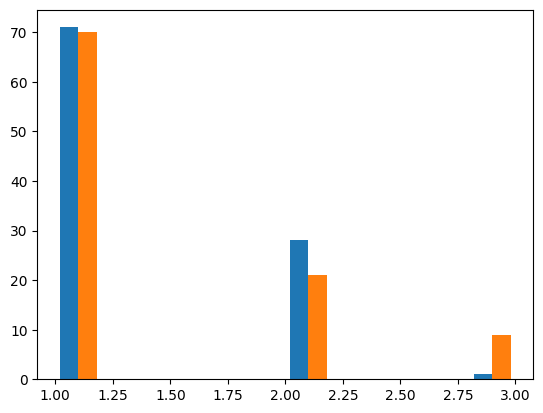

In [ ]:
df = pd.DataFrame(num_targets)
plt.hist(df)